In [21]:
import scanpy as sc 
import pandas as pd
import numpy as np
from scipy.stats import median_abs_deviation
import os
import warnings
import anndata as ad
from anndata import AnnData

warnings.filterwarnings('ignore') 

In [4]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor="white")

scanpy==1.9.8 anndata==0.10.5.post1 umap==0.5.5 numpy==1.26.4 scipy==1.12.0 pandas==2.2.1 scikit-learn==1.4.1.post1 statsmodels==0.14.1 igraph==0.11.4 pynndescent==0.5.11


In [9]:
results_file = "C:/Users/supak/github/resultsc/GSE184950_test.h5ad"

In [11]:
directory = 'C:/Users/supak/workplace/singlecell/GSE184950_RAW/data_selected/'
dirs = os.listdir(directory)
print(dirs)

['GSM5602315_A10_CTL_filtered_feature_bc_matrix', 'GSM5602316_A15_PDD_filtered_feature_bc_matrix', 'GSM5602317_A18_PDD_filtered_feature_bc_matrix', 'GSM5602318_A2_CTL_filtered_feature_bc_matrix']


### **Create AnnData object**

In [12]:
dfs = []

patient_adata_list = []

for filename in dirs:
    
    name = filename.replace('_filtered_feature_bc_matrix', '').split('_')
    Patient = name[1]
    Type = name[2]
    
    matrix_file = os.path.join(directory, filename)
    
    adata = sc.read_10x_mtx(matrix_file,
                            var_names='gene_symbols')
    
    adata.var_names_make_unique()
    
    patient_adata_list.append(adata)
        
    adata.obs['Patient'] = Patient
    adata.obs['Type'] = Type
    
    df = pd.DataFrame(adata.obs)
    
    dfs.append(df)
    
merge_df = pd.concat(dfs)



--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


In [14]:
merged_adata = ad.concat(patient_adata_list, join='outer', merge='same')

In [15]:
print(merged_adata.obs.value_counts())
print(merged_adata.obs.Patient)

Patient  Type
A18      PDD     17752
A15      PDD     11760
A2       CTL     11055
A10      CTL      2165
Name: count, dtype: int64
AAACCCACATCGCTAA-1    A10
AAACCCATCACATACG-1    A10
AAACCCATCGCAACAT-1    A10
AAACGAATCACAATGC-1    A10
AAACGAATCTAACGCA-1    A10
                     ... 
TTTGTTGCAGACTGCC-1     A2
TTTGTTGGTGTCTTGA-1     A2
TTTGTTGTCGAGTTGT-1     A2
TTTGTTGTCTGTAAGC-1     A2
TTTGTTGTCTTACGTT-1     A2
Name: Patient, Length: 42732, dtype: object


In [27]:
merged_adata.var["mt"] = merged_adata.var_names.str.startswith("MT-")

sc.pp.calculate_qc_metrics(
    merged_adata, qc_vars=["mt"], 
    percent_top=[20], 
    log1p=True, 
    inplace=True)

In [28]:
merged_adata

AnnData object with n_obs × n_vars = 42732 × 33538
    obs: 'Patient', 'Type', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'log1p_total_counts_mt', 'outlier', 'mt_outlier', 'pct_counts_in_top_20_genes'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_mean_counts', 'log1p_total_counts'

### **Plot QC**

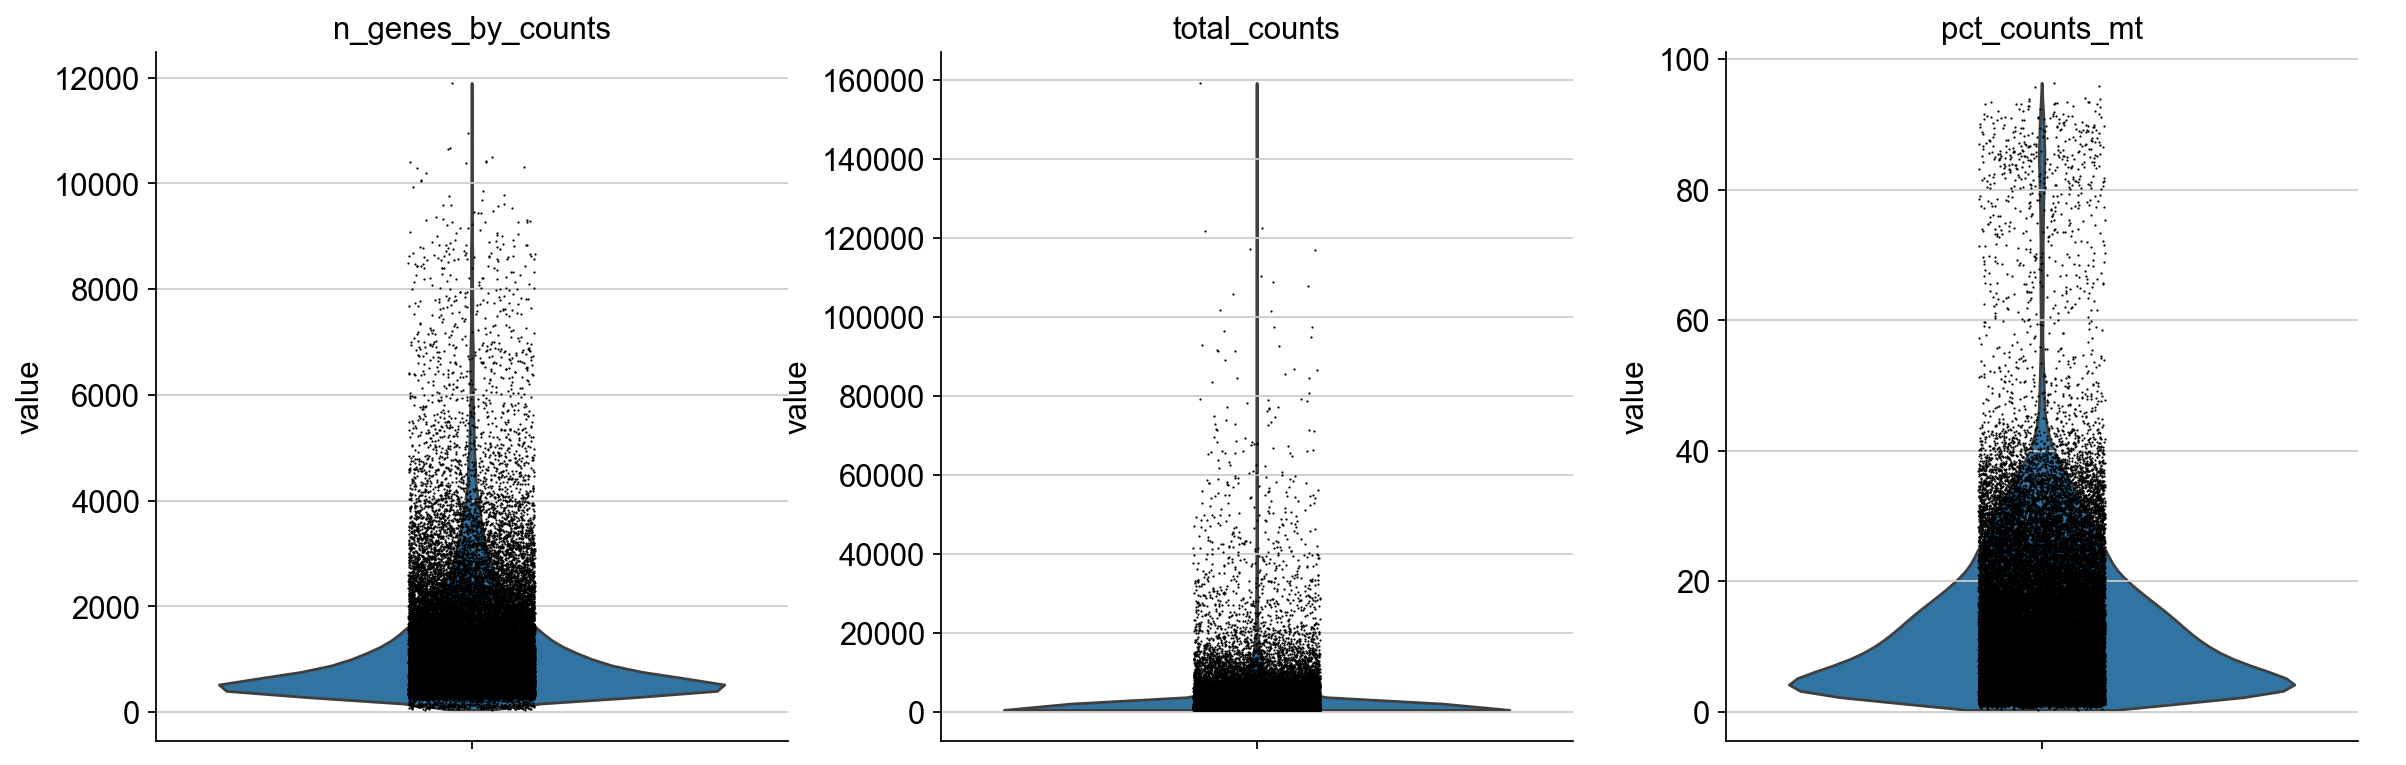

In [18]:
sc.pl.violin(
    merged_adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.1,
    multi_panel=True)

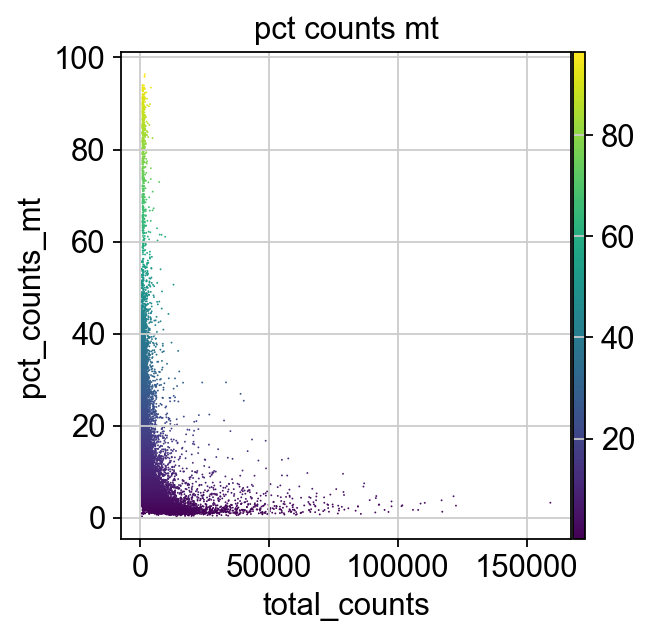

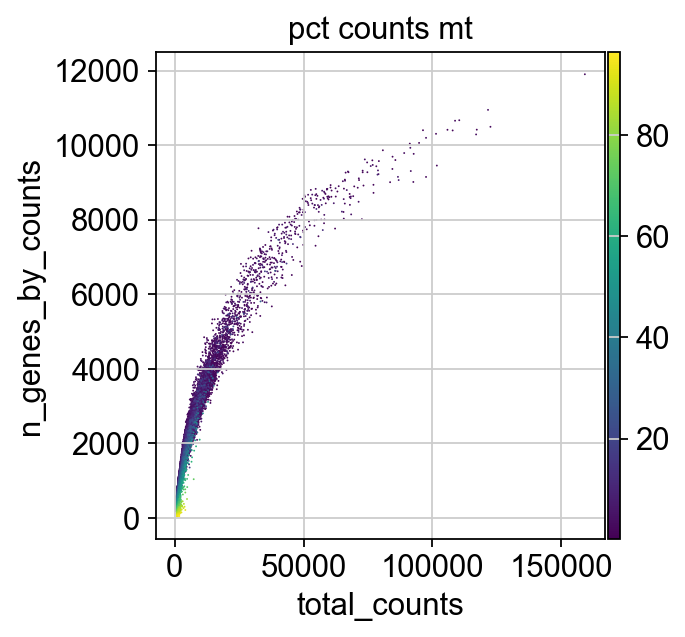

In [19]:
sc.pl.scatter(merged_adata, x="total_counts", y="pct_counts_mt", color="pct_counts_mt")
sc.pl.scatter(merged_adata, x="total_counts", y="n_genes_by_counts", color="pct_counts_mt")

## **Outlier Threshold**

### ***MAD = median(|Xi - median(X)|)***
Xi is the respective QC metric of an observation and 
describes a robust statistic of the variability of the metric.
[Germain et al., 2020]

In [24]:
def is_outlier(merged_adata, metric: str, nmads: int):
    M = merged_adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

In [29]:
merged_adata.obs["outlier"] = (
    is_outlier(merged_adata, "log1p_total_counts", 5) |
    is_outlier(merged_adata, "log1p_n_genes_by_counts", 5) |
    is_outlier(merged_adata, "pct_counts_in_top_20_genes", 5)   
)
merged_adata.obs.outlier.value_counts()

outlier
False    41641
True      1091
Name: count, dtype: int64

In [47]:
merged_adata.obs["mt_outlier"] = is_outlier(merged_adata, "pct_counts_mt", 3) | (
    merged_adata.obs["pct_counts_mt"] > 20
)
merged_adata.obs.mt_outlier.value_counts()

mt_outlier
False    32161
Name: count, dtype: int64

In [44]:
print(f"Total number of cells: {merged_adata.n_obs}")
merged_adata = merged_adata[(~merged_adata.obs.outlier) & (~merged_adata.obs.mt_outlier)].copy()

print(f"Number of cells after filtering of low quality cells: {merged_adata.n_obs}")

Total number of cells: 42732
Number of cells after filtering of low quality cells: 32161


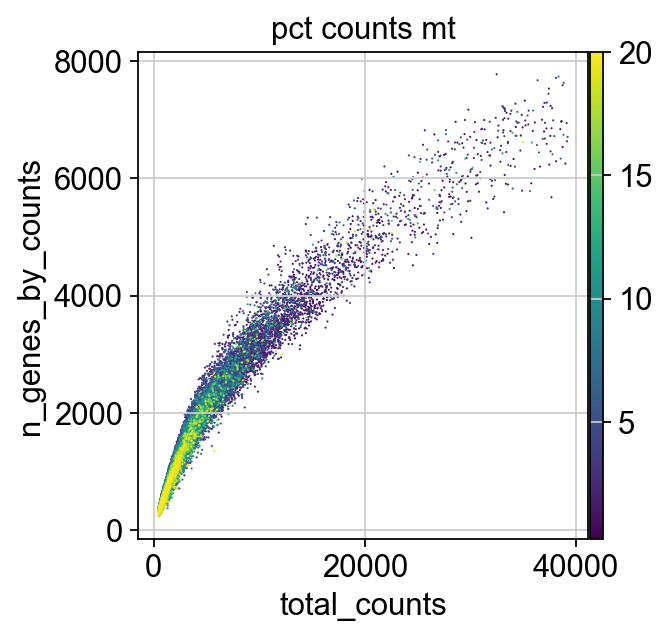

In [45]:
sc.pl.scatter(merged_adata, x="total_counts", y="n_genes_by_counts", color="pct_counts_mt")

### **Filtering**

In [49]:
print(f"Total number of genes: {adata.n_vars}")
sc.pp.filter_genes(merged_adata, min_cells=3)
print(f"Number of genes after cell filter: {merged_adata.n_vars}")

#sc.pp.filter_cells(merged_adata, max_genes=5000)
#merged_adata = merged_adata[merged_adata.obs.pct_counts_mt < 20, :]
#merged_adata = merged_adata[merged_adata.obs.total_counts < 20000, :]
#merged_adata = merged_adata[merged_adata.obs.total_counts > 300, :]

Total number of genes: 33538
Number of genes after cell filter: 25877


In [50]:
merged_adata

AnnData object with n_obs × n_vars = 32161 × 25877
    obs: 'Patient', 'Type', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'log1p_total_counts_mt', 'outlier', 'mt_outlier', 'pct_counts_in_top_20_genes'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_mean_counts', 'log1p_total_counts', 'n_cells'

normalizing counts per cell
    finished (0:00:00)


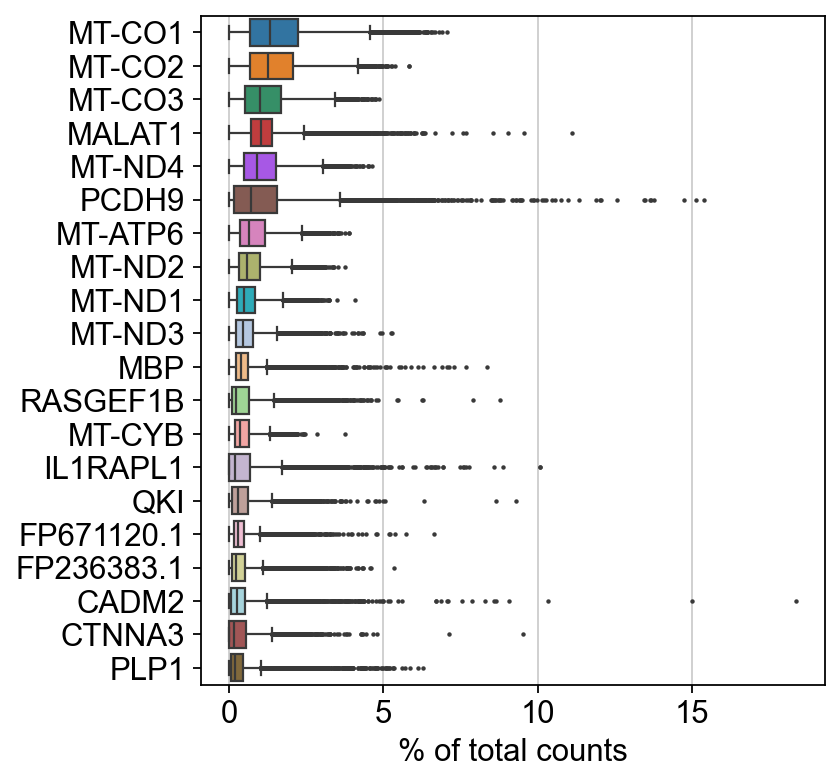

In [51]:
sc.pl.highest_expr_genes(merged_adata, n_top=20)

### **Plot after filtering**

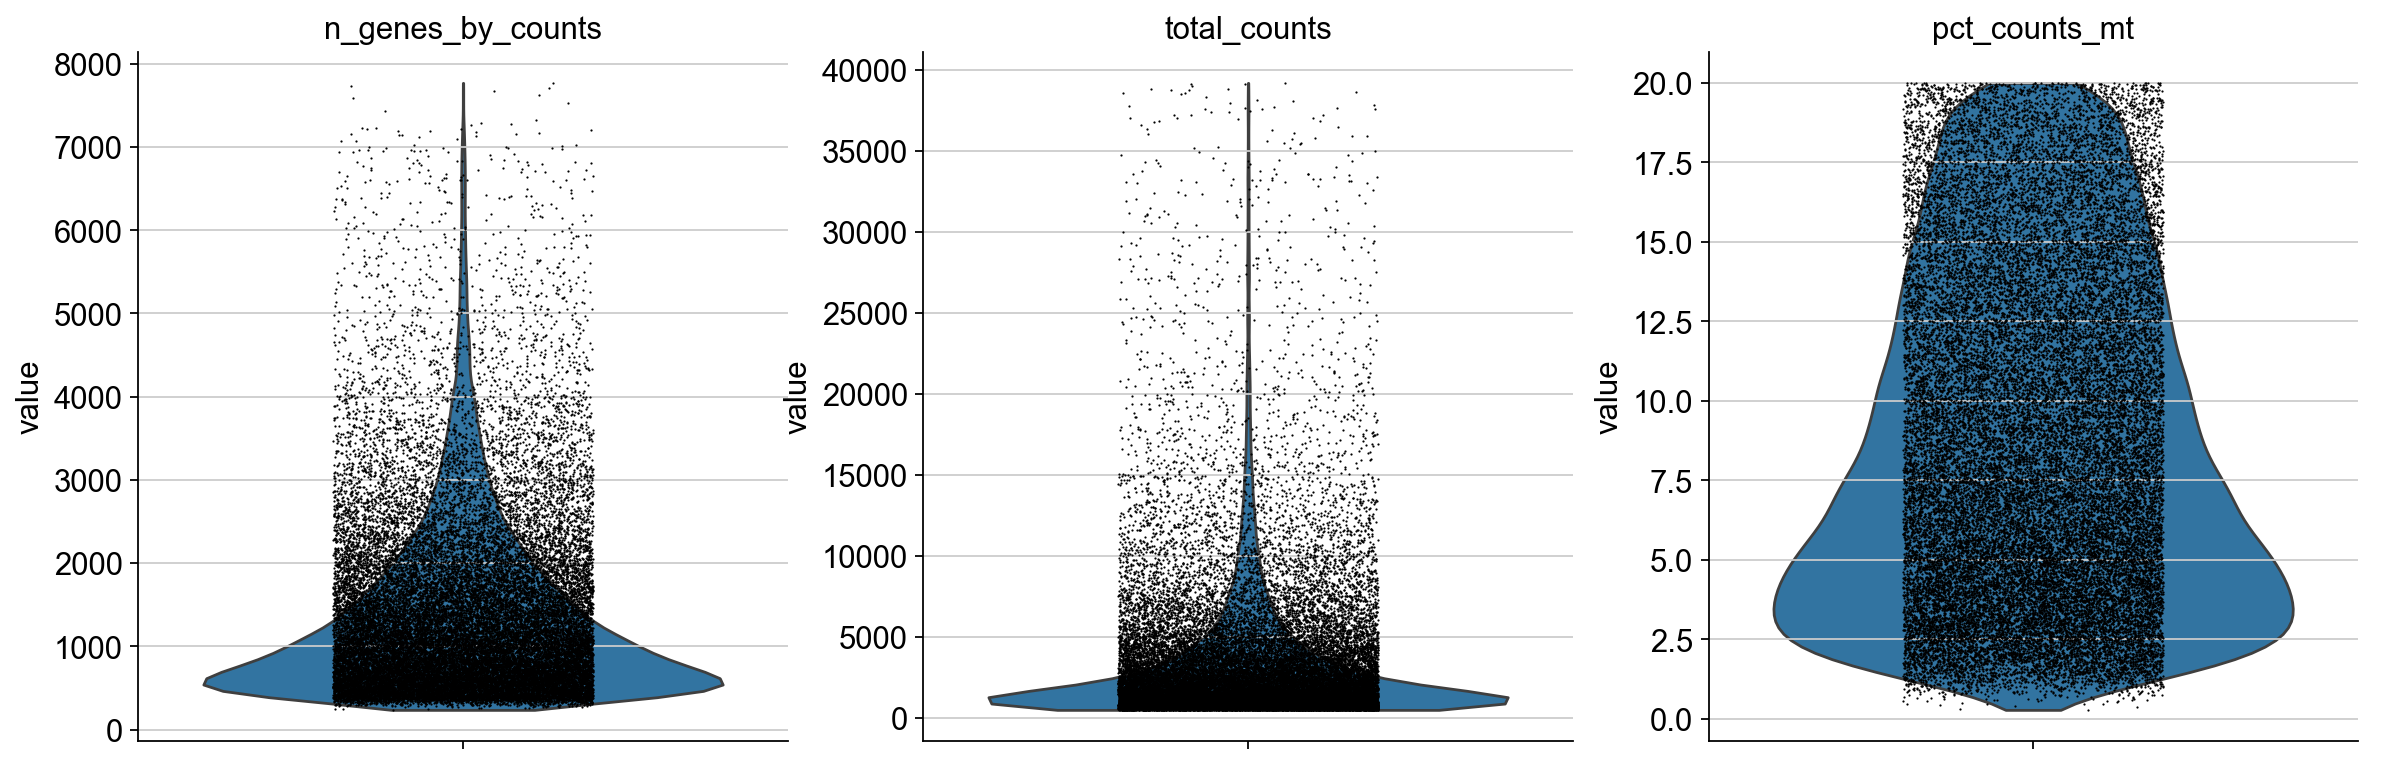

In [52]:
sc.pl.violin(
    merged_adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.2,
    multi_panel=True)

### **Normalization**

In [53]:
sc.pp.normalize_total(merged_adata, target_sum=1e4)

normalizing counts per cell


    finished (0:00:00)


In [54]:
sc.pp.log1p(merged_adata)

In [55]:
sc.pp.highly_variable_genes(merged_adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


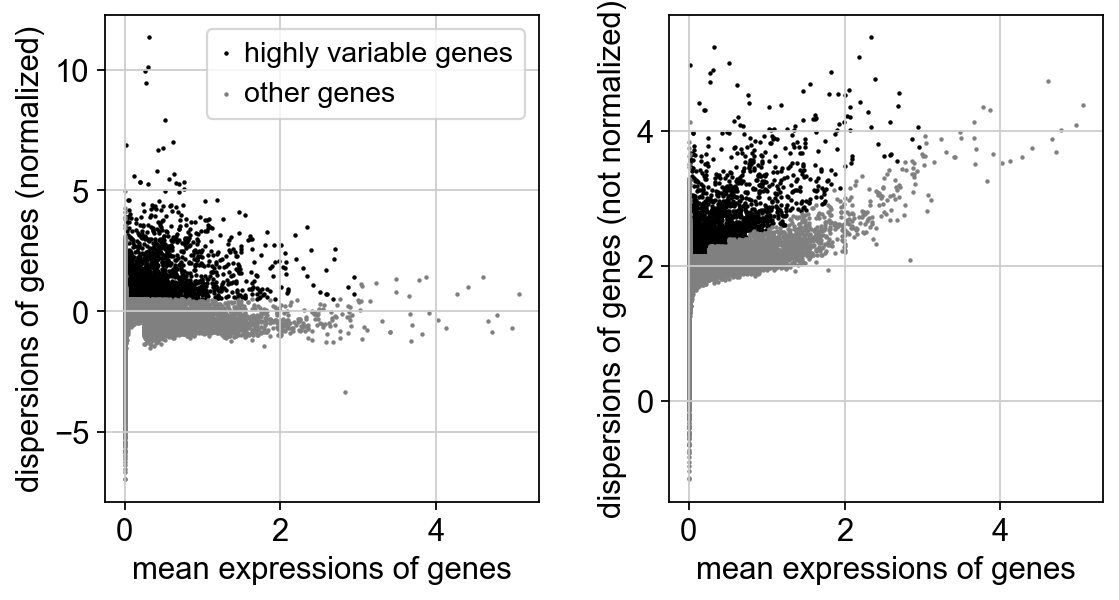

In [56]:
sc.pl.highly_variable_genes(merged_adata)

**Create .raw file**

In [57]:
merged_adata.raw = merged_adata

In [58]:
merged_adata = merged_adata[:, merged_adata.var.highly_variable]

### **Regress out unwanted variable**

In [59]:
sc.pp.regress_out(merged_adata, ["pct_counts_mt", "total_counts"])

regressing out ['pct_counts_mt', 'total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:02:14)


### **Scale Data**

In [60]:
sc.pp.scale(merged_adata, max_value=10)

### **Plot PCA**

In [61]:
sc.tl.pca(merged_adata, svd_solver="arpack")

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:06)


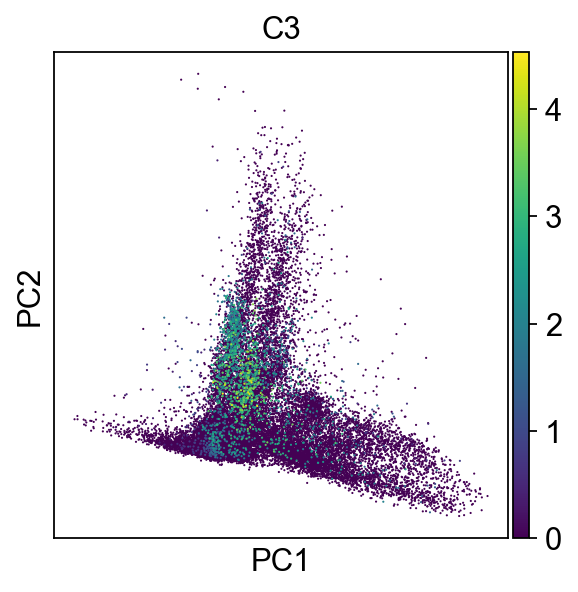

In [62]:
sc.pl.pca(merged_adata, color="C3")

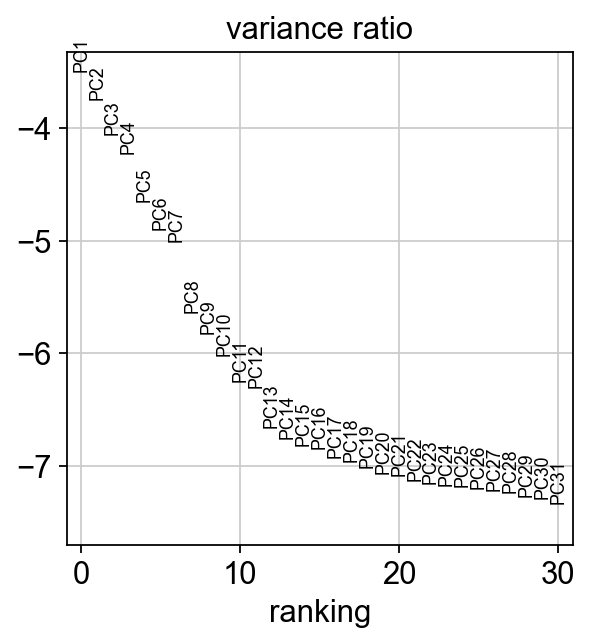

In [63]:
sc.pl.pca_variance_ratio(merged_adata, log=True)

In [64]:
merged_adata.write(results_file)

### **Find Neighbors and Plot UMAP**

In [65]:
sc.pp.neighbors(merged_adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:17)


In [66]:
sc.tl.umap(merged_adata)

computing UMAP


    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:18)


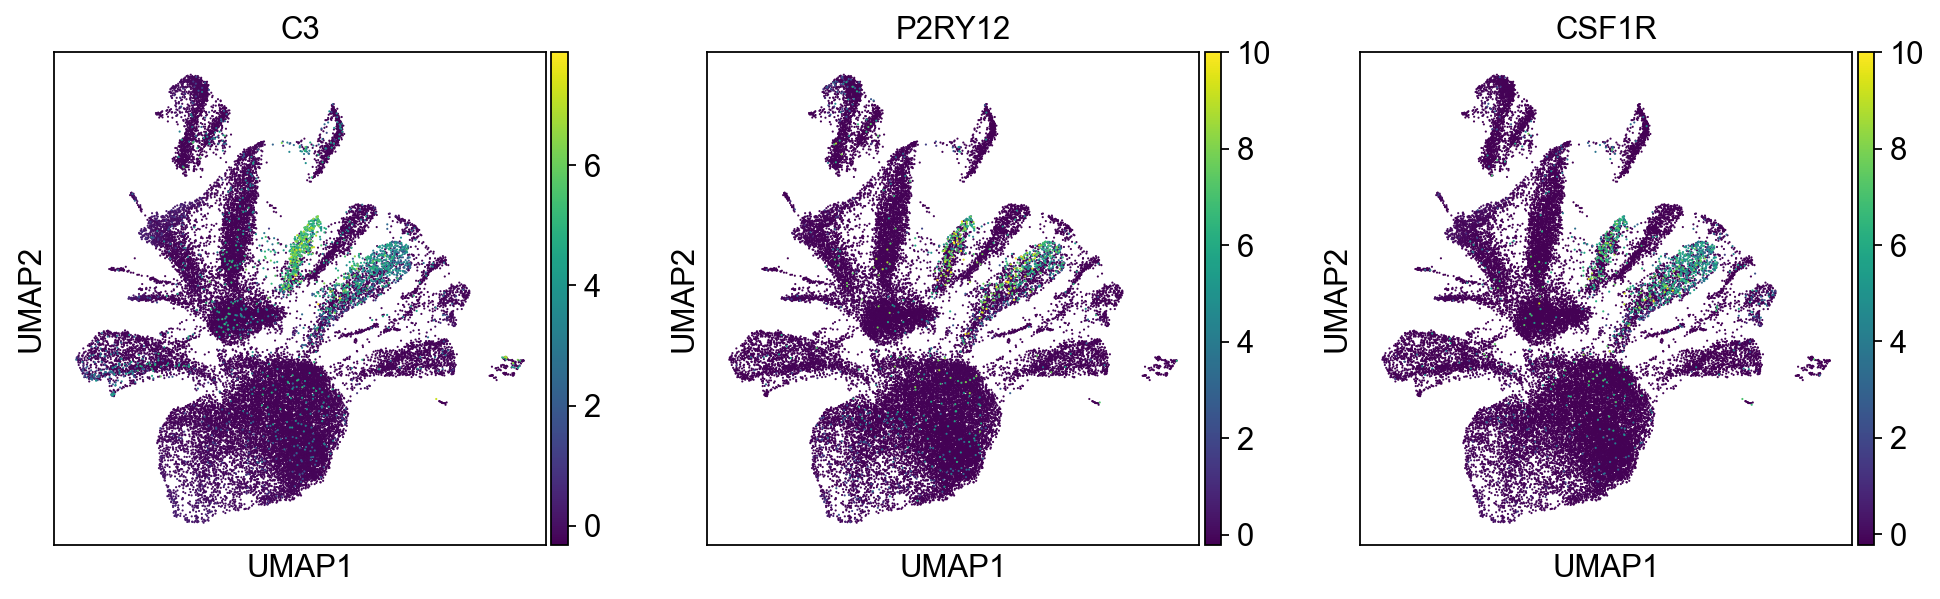

In [67]:
sc.pl.umap(merged_adata, color=["C3", "P2RY12", "CSF1R"], use_raw=False)

### **Clustering**

In [68]:
sc.tl.leiden(
    merged_adata,
    resolution=0.5,
    random_state=0,
    n_iterations=2,
    directed=False,
)

running Leiden clustering
    finished: found 18 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)


In [69]:
merged_adata.var_names

Index(['NOC2L', 'HES4', 'ISG15', 'SDF4', 'B3GALT6', 'CPTP', 'DVL1', 'MXRA8',
       'AURKAIP1', 'MRPL20',
       ...
       'SUMO3', 'ITGB2', 'AP001505.1', 'ADARB1', 'SLC19A1', 'PCBP3', 'COL6A1',
       'COL6A2', 'FTCD', 'AC007325.4'],
      dtype='object', length=4470)

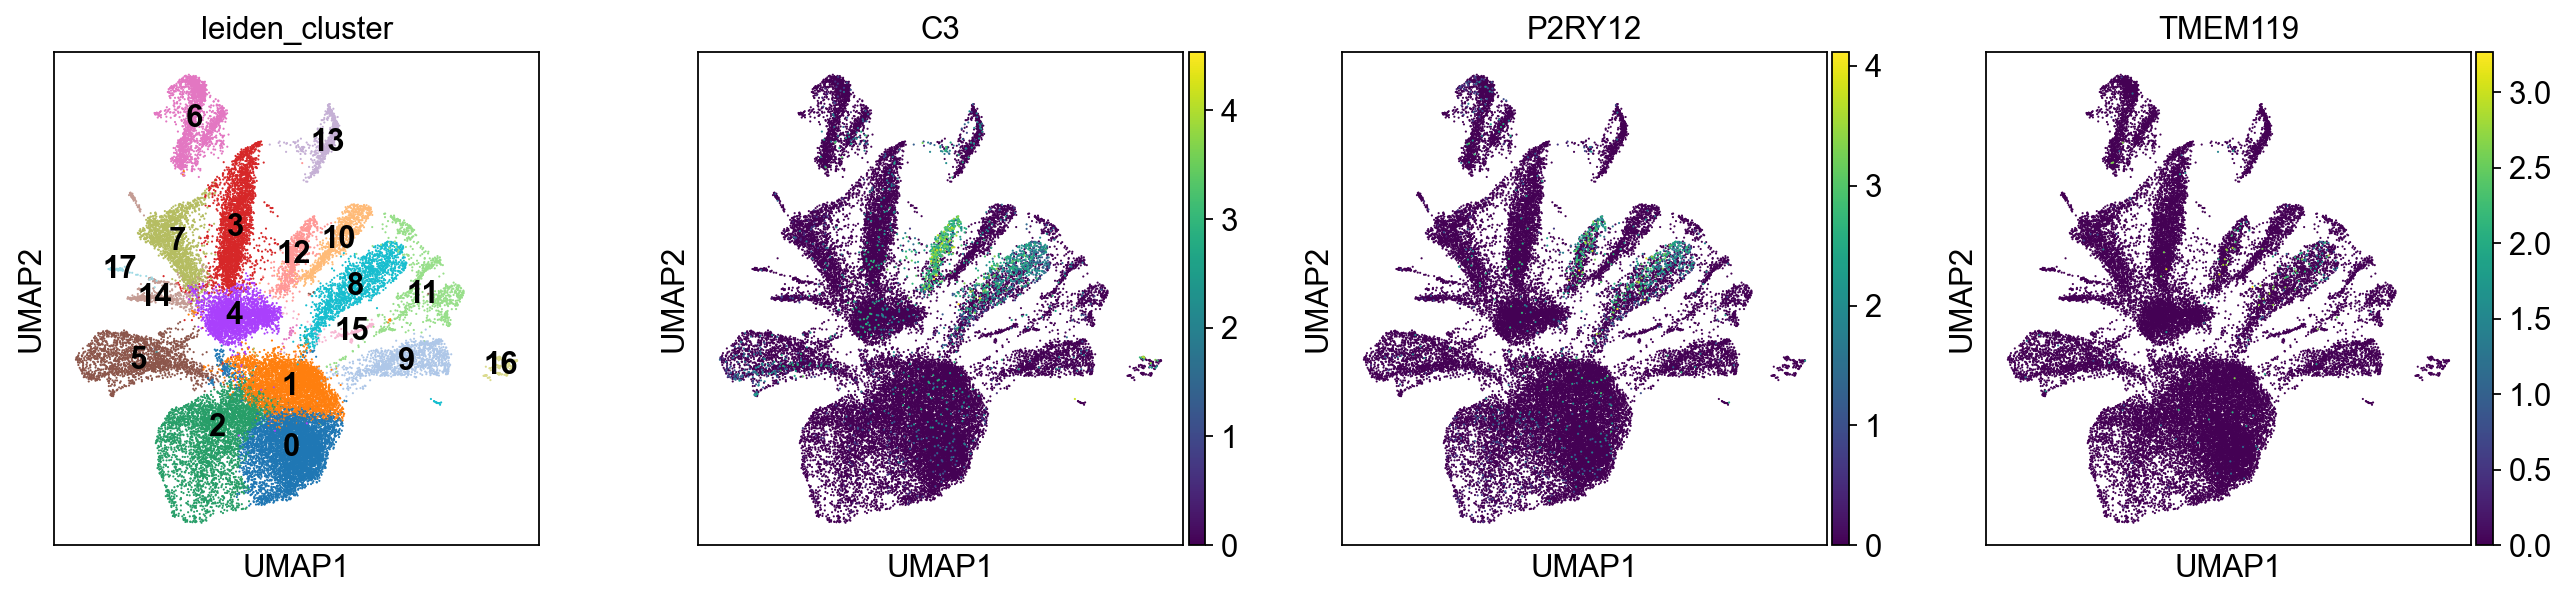

In [70]:
sc.pl.umap(merged_adata, color=["leiden", "C3", "P2RY12", "TMEM119"], legend_loc="on data", title="leiden_cluster")

In [71]:
merged_adata.write(results_file)

### **Rank Gene Group**

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:06)


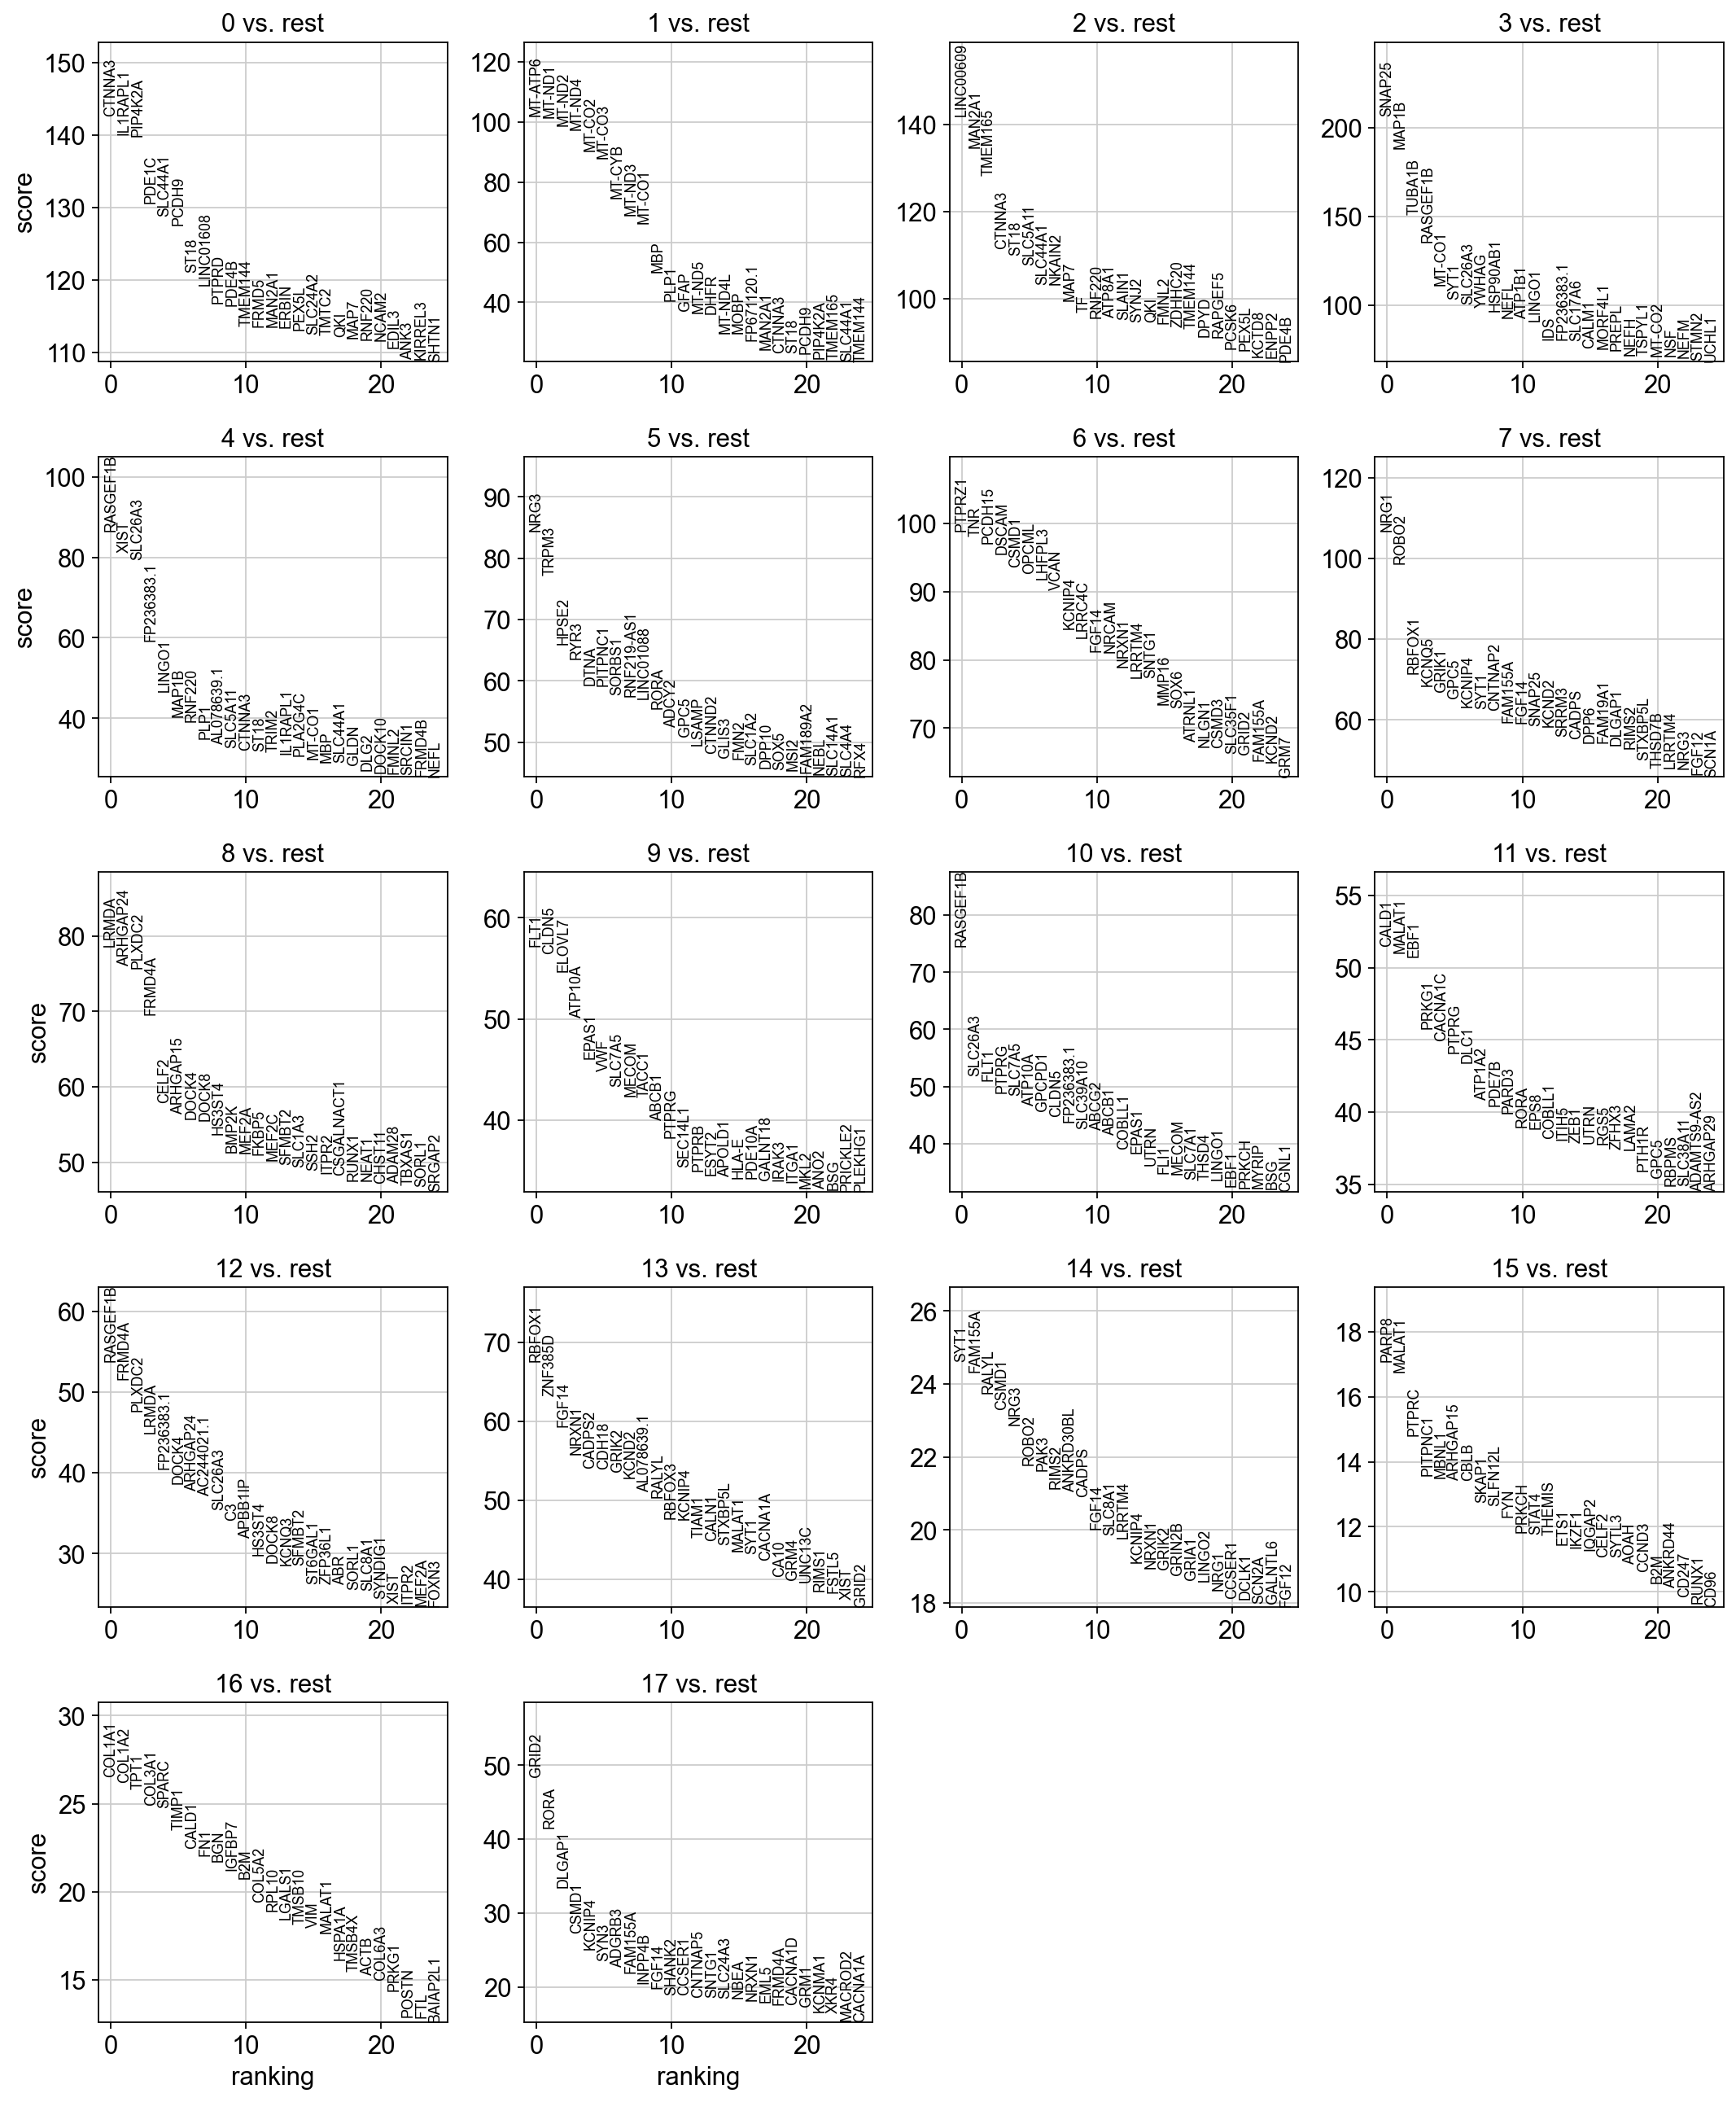

In [72]:
# Methods can be 't-test', 't-test_overestim_var' for overreestimates varience of each group
# 'wilcoxon' for rank-sum
# 'logreg' for logistic regression

sc.tl.rank_genes_groups(merged_adata, "leiden", method="t-test")
sc.pl.rank_genes_groups(merged_adata, n_genes=25, sharey=False, ncols=4)

In [73]:
sc.settings.verbosity = 2  # reduce the verbosity

ranking genes
    finished (0:01:30)


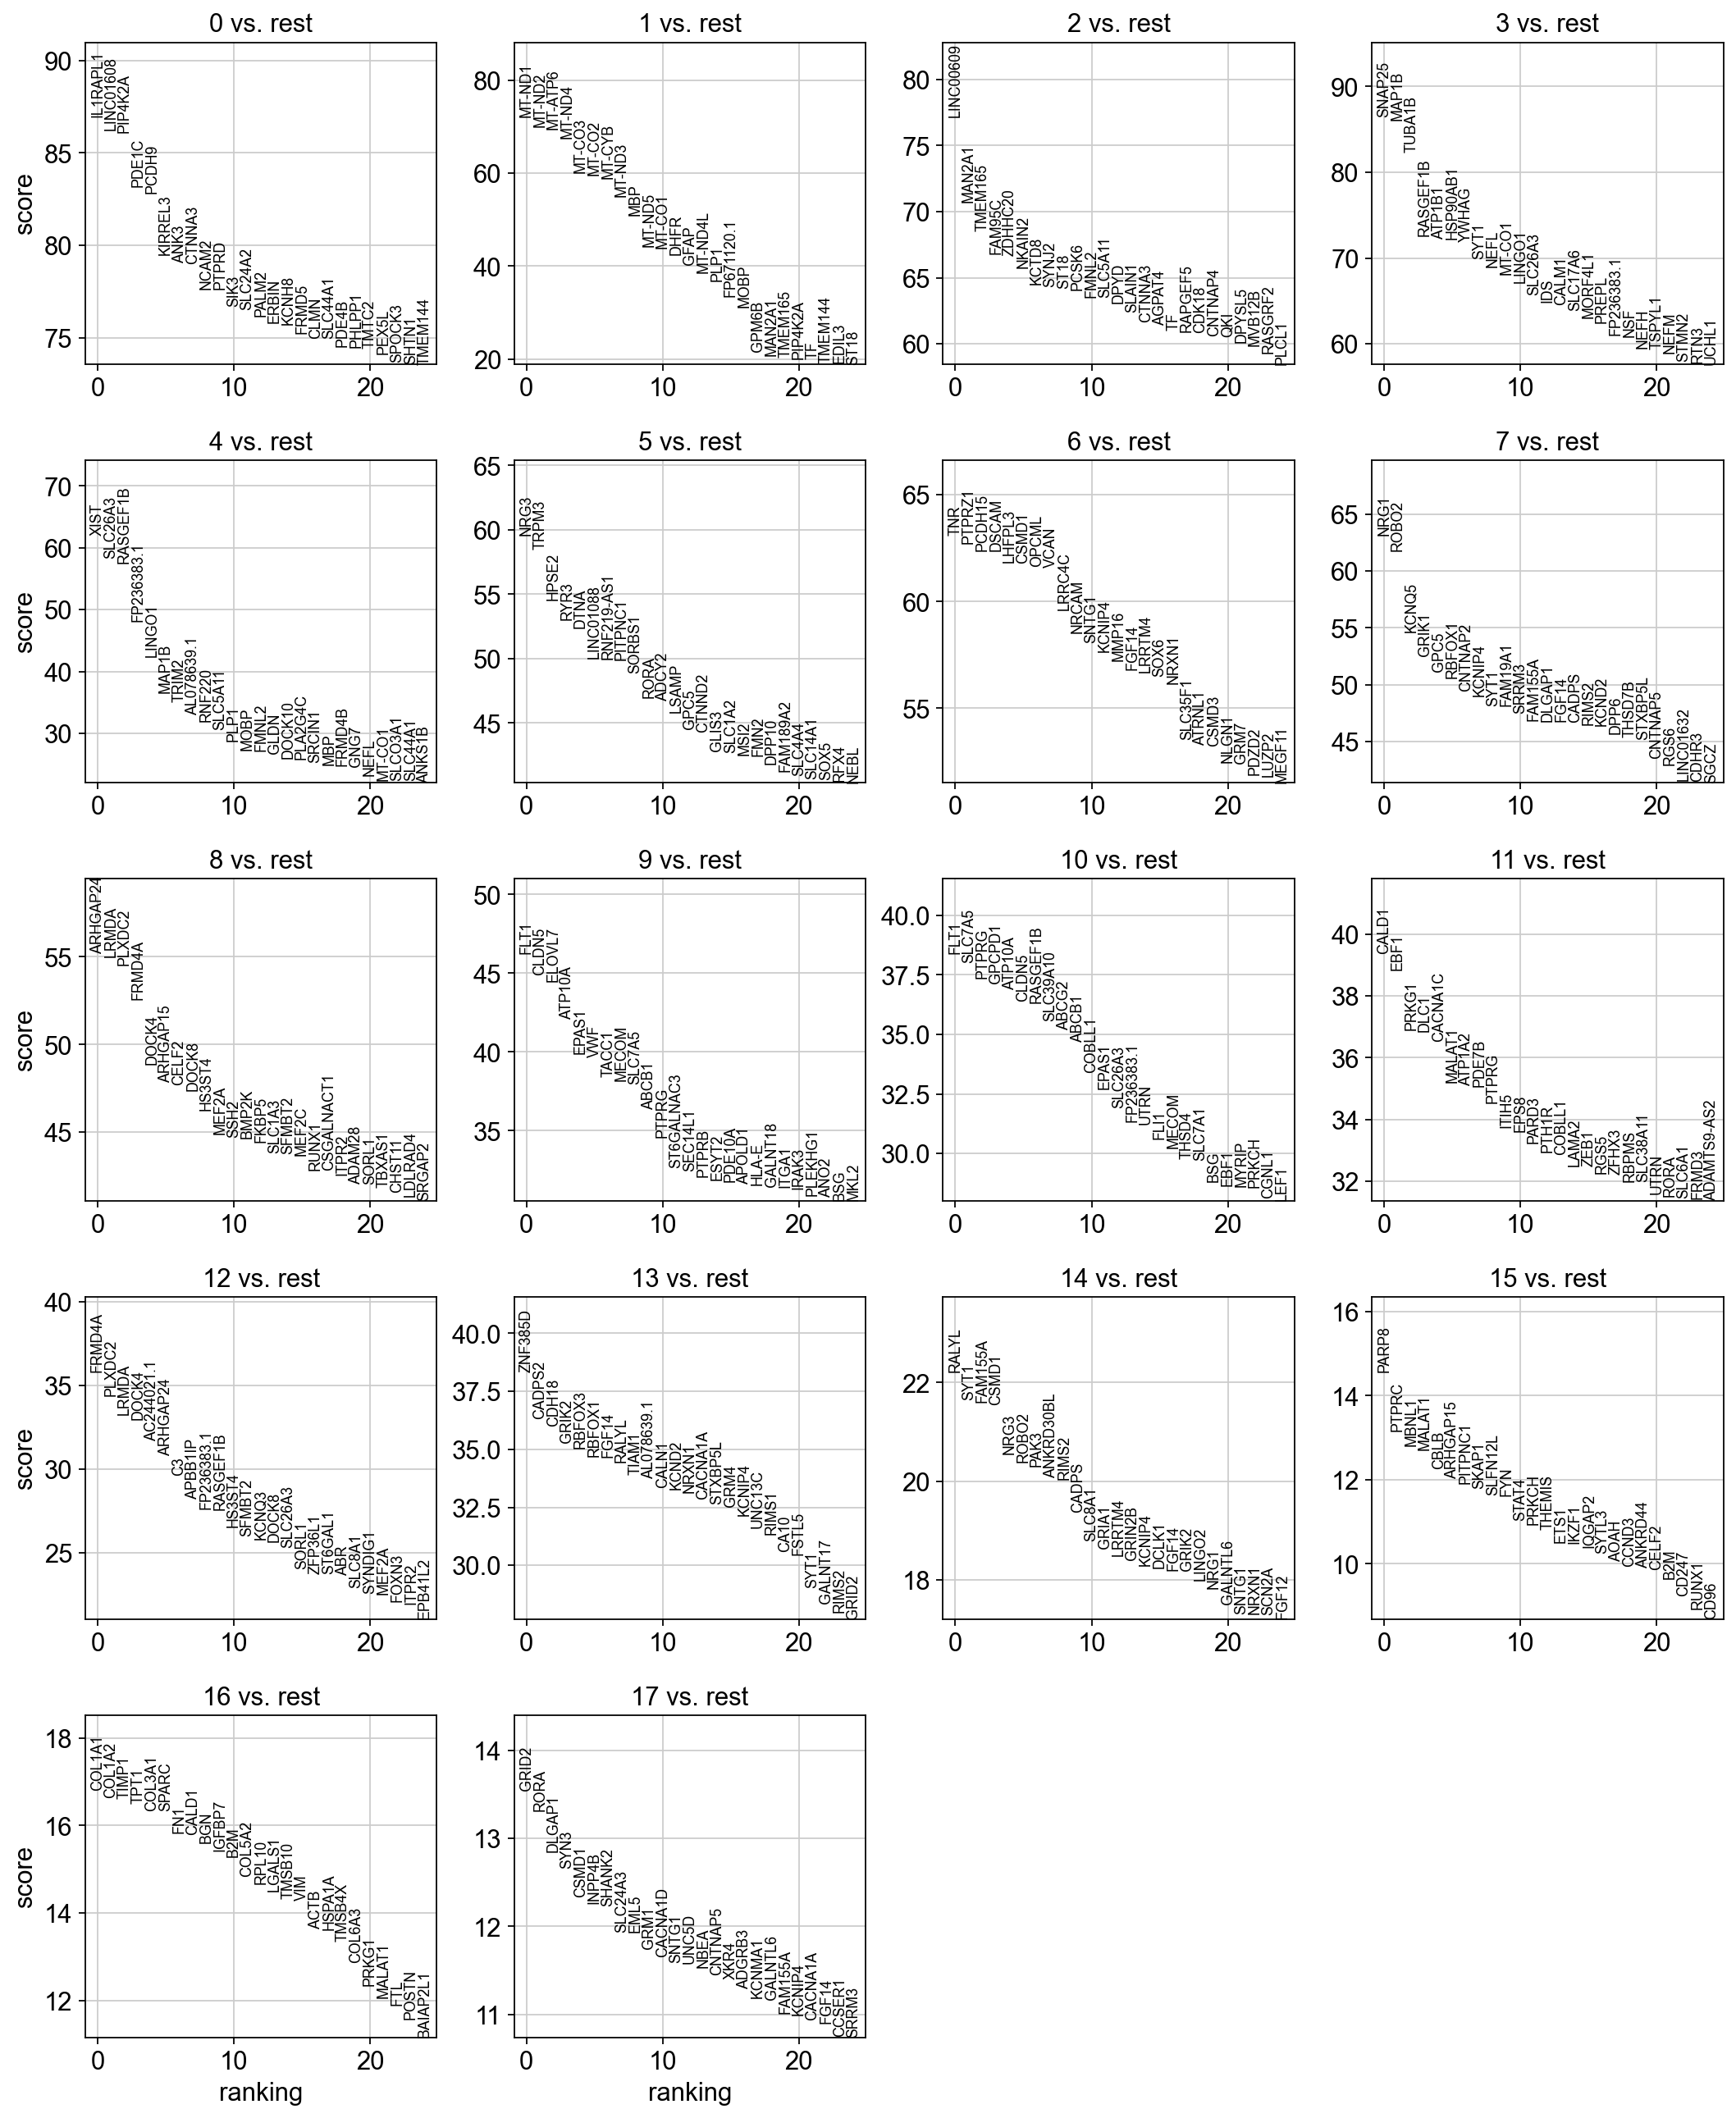

In [74]:
sc.tl.rank_genes_groups(merged_adata, "leiden", method="wilcoxon")
sc.pl.rank_genes_groups(merged_adata, n_genes=25, sharey=False, ncols=4)

In [75]:
merged_adata.write(results_file)

ranking genes
    finished (0:02:16)


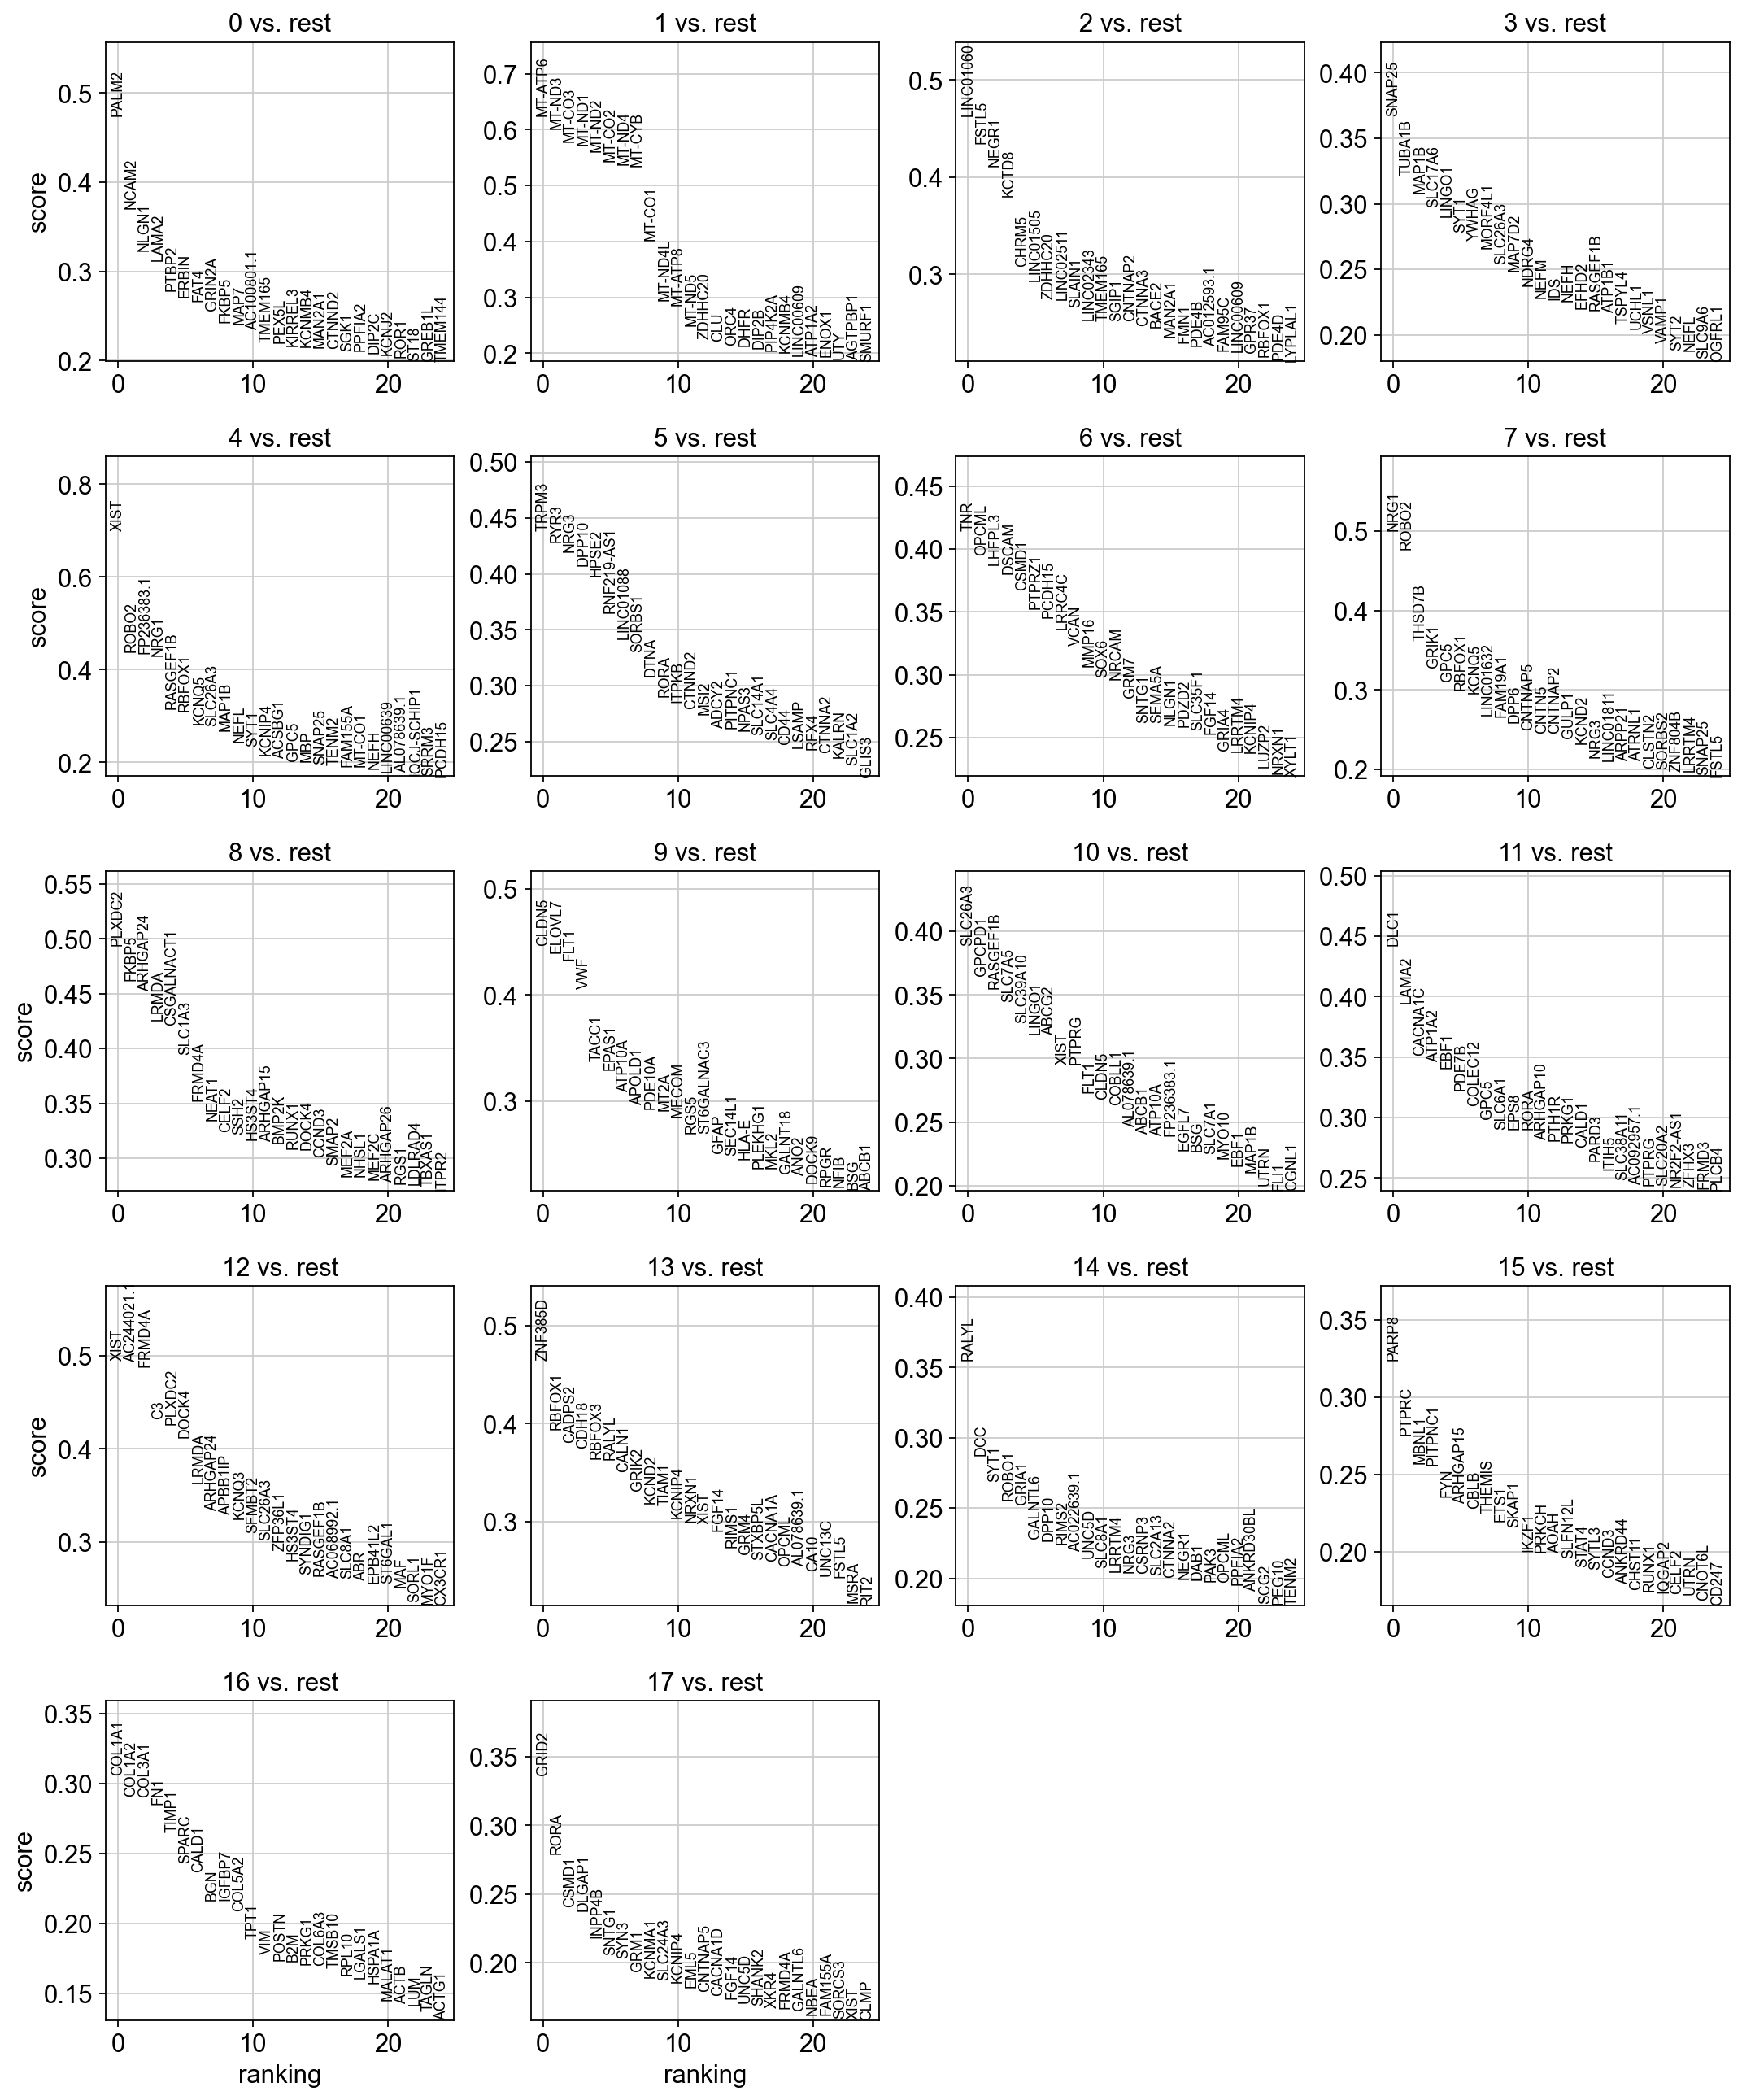

In [76]:
sc.tl.rank_genes_groups(merged_adata, "leiden", method="logreg", max_iter=1000)
sc.pl.rank_genes_groups(merged_adata, n_genes=25, sharey=False, ncols=4)

In [77]:
merged_adata = sc.read(results_file)

In [78]:
pd.DataFrame(merged_adata.uns["rank_genes_groups"]["names"]).head(10)

0        1          2         3           4           5       6  \
0   IL1RAPL1   MT-ND1  LINC00609    SNAP25        XIST        NRG3     TNR   
1  LINC01608   MT-ND2     MAN2A1     MAP1B     SLC26A3       TRPM3  PTPRZ1   
2    PIP4K2A  MT-ATP6    TMEM165    TUBA1B    RASGEF1B       HPSE2  PCDH15   
3      PDE1C   MT-ND4     FAM95C  RASGEF1B  FP236383.1        RYR3   DSCAM   
4      PCDH9   MT-CO3    ZDHHC20    ATP1B1      LINGO1        DTNA  LHFPL3   
5    KIRREL3   MT-CO2     NKAIN2  HSP90AB1       MAP1B   LINC01088   CSMD1   
6       ANK3   MT-CYB      KCTD8     YWHAG       TRIM2  RNF219-AS1   OPCML   
7     CTNNA3   MT-ND3      SYNJ2      SYT1  AL078639.1     PITPNC1    VCAN   
8      NCAM2      MBP       ST18      NEFL      RNF220      SORBS1  LRRC4C   
9      PTPRD   MT-ND5      PCSK6    MT-CO1     SLC5A11        RORA   NRCAM   

         7         8       9        10       11          12          13  \
0     NRG1  ARHGAP24    FLT1      FLT1    CALD1      FRMD4A     ZNF385D   
1    ROBO2     LRMDA   CLDN5    SLC7A5     EBF1      PLXDC2      CADPS2   
2    KCNQ5    PLXDC2  ELOVL7     PTPRG    PRKG1       LRMDA       CDH18   
3    GRIK1    FRMD4A  ATP10A    GPCPD1     DLC1       DOCK4       GRIK2   
4     GPC5     DOCK4   EPAS1    ATP10A  CACNA1C  AC244021.1      RBFOX3   
5   RBFOX1  ARHGAP15     VWF     CLDN5   MALAT1    ARHGAP24      RBFOX1   
6  CNTNAP2     CELF2   TACC1  RASGEF1B   ATP1A2          C3       FGF14   
7   KCNIP4     DOCK8   MECOM  SLC39A10    PDE7B     APBB1IP       RALYL   
8     SYT1    HS3ST4  SLC7A5     ABCG2    PTPRG  FP236383.1       TIAM1   
9  FAM19A1     MEF2A   ABCB1     ABCB1    ITIH5    RASGEF1B  AL078639.1   

          14        15      16       17  
0      RALYL     PARP8  COL1A1    GRID2  
1       SYT1     PTPRC  COL1A2     RORA  
2    FAM155A     MBNL1   TIMP1   DLGAP1  
3      CSMD1    MALAT1    TPT1     SYN3  
4       NRG3      CBLB  COL3A1    CSMD1  
5      ROBO2  ARHGAP15   SPARC   INPP4B  
6       PAK3   PITPNC1     FN1   SHANK2  
7  ANKRD30BL     SKAP1   CALD1  SLC24A3  
8      RIMS2   SLFN12L     BGN     EML5  
9      CADPS       FYN  IGFBP7     GRM1

In [79]:
result = merged_adata.uns["rank_genes_groups"]
groups = result["names"].dtype.names
pd.DataFrame(
    {
        group + "_" + key[:1]: result[key][group]
        for group in groups
        for key in ["names", "pvals"]
    }
).head(10)

0_n  0_p      1_n  1_p        2_n  2_p       3_n  3_p         4_n  \
0   IL1RAPL1  0.0   MT-ND1  0.0  LINC00609  0.0    SNAP25  0.0        XIST   
1  LINC01608  0.0   MT-ND2  0.0     MAN2A1  0.0     MAP1B  0.0     SLC26A3   
2    PIP4K2A  0.0  MT-ATP6  0.0    TMEM165  0.0    TUBA1B  0.0    RASGEF1B   
3      PDE1C  0.0   MT-ND4  0.0     FAM95C  0.0  RASGEF1B  0.0  FP236383.1   
4      PCDH9  0.0   MT-CO3  0.0    ZDHHC20  0.0    ATP1B1  0.0      LINGO1   
5    KIRREL3  0.0   MT-CO2  0.0     NKAIN2  0.0  HSP90AB1  0.0       MAP1B   
6       ANK3  0.0   MT-CYB  0.0      KCTD8  0.0     YWHAG  0.0       TRIM2   
7     CTNNA3  0.0   MT-ND3  0.0      SYNJ2  0.0      SYT1  0.0  AL078639.1   
8      NCAM2  0.0      MBP  0.0       ST18  0.0      NEFL  0.0      RNF220   
9      PTPRD  0.0   MT-ND5  0.0      PCSK6  0.0    MT-CO1  0.0     SLC5A11   

             4_p  ...        13_n           13_p       14_n           14_p  \
0   0.000000e+00  ...     ZNF385D   0.000000e+00      RALYL  2.117197e-109   
1   0.000000e+00  ...      CADPS2  3.153279e-289       SYT1  6.746573e-104   
2   0.000000e+00  ...       CDH18  3.517799e-284    FAM155A  1.608583e-103   
3   0.000000e+00  ...       GRIK2  3.378116e-273      CSMD1  5.045723e-103   
4   0.000000e+00  ...      RBFOX3  2.989090e-269       NRG3   6.263017e-94   
5  3.241068e-293  ...      RBFOX1  5.750839e-264      ROBO2   2.174823e-92   
6  2.683454e-270  ...       FGF14  2.389015e-263       PAK3   1.281814e-91   
7  1.231033e-239  ...       RALYL  4.965366e-260  ANKRD30BL   1.260273e-89   
8  2.438747e-224  ...       TIAM1  4.115989e-252      RIMS2   2.919973e-89   
9  6.819228e-206  ...  AL078639.1  8.688580e-250      CADPS   1.391597e-83   

       15_n          15_p    16_n          16_p     17_n          17_p  
0     PARP8  3.931648e-48  COL1A1  1.906019e-63    GRID2  7.736138e-42  
1     PTPRC  1.309841e-39  COL1A2  3.500406e-62     RORA  1.775960e-40  
2     MBNL1  1.562732e-37   TIMP1  5.396432e-62   DLGAP1  8.471650e-38  
3    MALAT1  4.708806e-37    TPT1  3.310848e-61     SYN3  9.910746e-37  
4      CBLB  1.514250e-34  COL3A1  5.001480e-60    CSMD1  5.481708e-35  
5  ARHGAP15  2.310378e-33   SPARC  5.692531e-60   INPP4B  1.492724e-34  
6   PITPNC1  1.088204e-32     FN1  1.849551e-56   SHANK2  2.034440e-34  
7     SKAP1  4.304779e-32   CALD1  3.632343e-56  SLC24A3  7.868160e-33  
8   SLFN12L  2.654808e-31     BGN  6.653718e-55     EML5  7.900977e-33  
9       FYN  2.871972e-31  IGFBP7  1.099916e-53     GRM1  7.020283e-32  

[10 rows x 36 columns]

ranking genes
    finished (0:00:09)


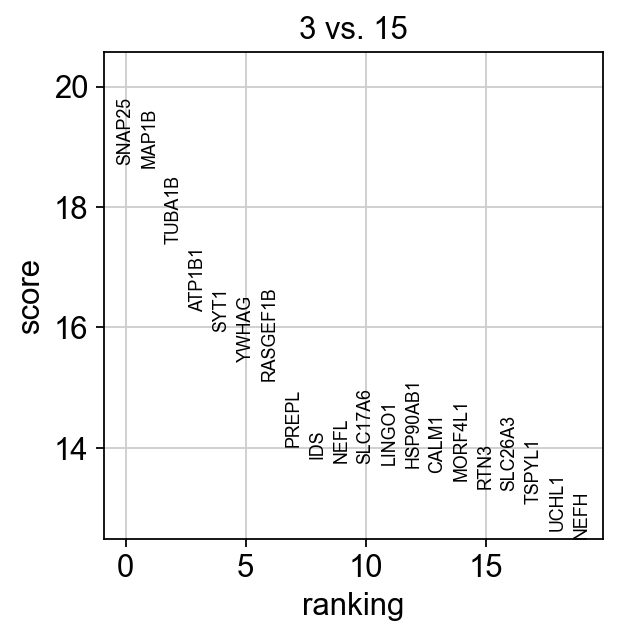

In [80]:
sc.tl.rank_genes_groups(merged_adata, "leiden", groups=["3"], reference="15", method="wilcoxon")
sc.pl.rank_genes_groups(merged_adata, groups=["3"], n_genes=20)

In [81]:
merged_adata = sc.read(results_file)

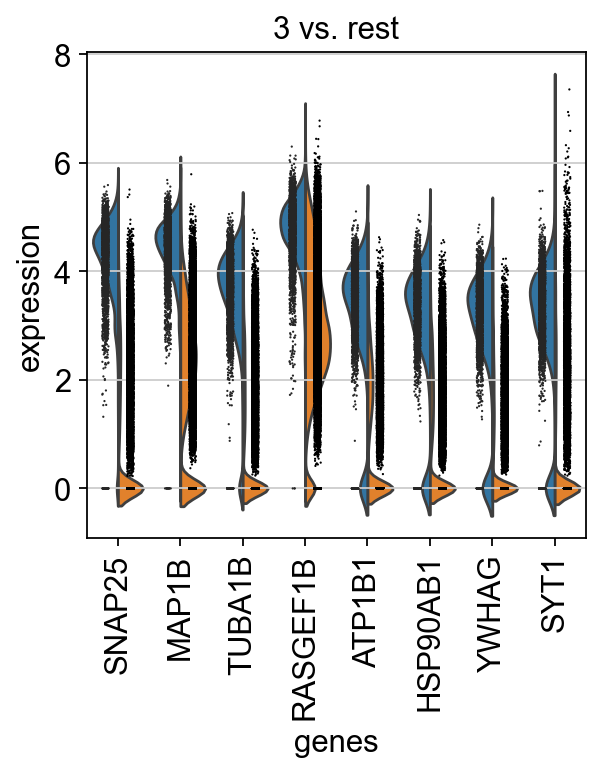

In [82]:
sc.pl.rank_genes_groups_violin(merged_adata, groups="3", n_genes=8)

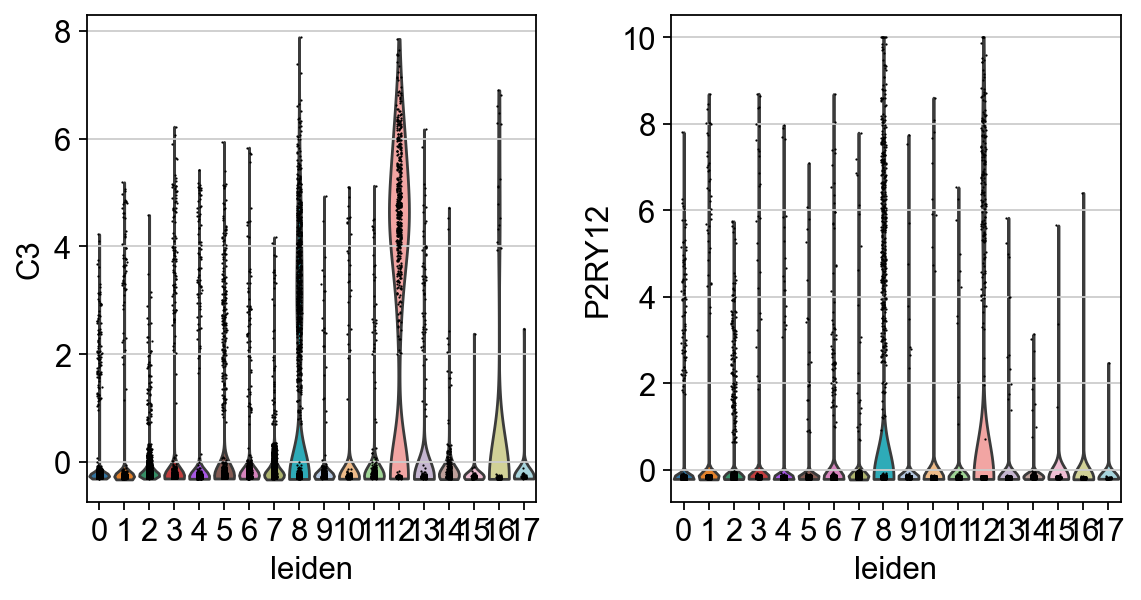

In [83]:
sc.pl.violin(merged_adata, ["C3", "P2RY12"], groupby= "leiden", use_raw=False)